**Rozdział 15. Przetwarzanie sekwencji za pomocą sieci rekurencyjnych i splotowych**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 15._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza i TensorFlow 2.0 lub nowszy.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version istnieje jedynie w środowisku Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# Wymagany moduł TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("Nie wykryto procesora graficznego. Bez niego komórki LSTM i sieci splotowe mogą działać bardzo powoli.")
    if IS_COLAB:
        print("Kliknij Runtime > Change runtime i wybierz akcelerator graficzny.")

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)
tf.random.set_seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R15"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


# Podstawowe sieci rekurencyjne

### Generowanie zestawu danych

In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   fala 1.
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + fala 2.
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + szum
    return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Zapisywanie rysunku r_15_6


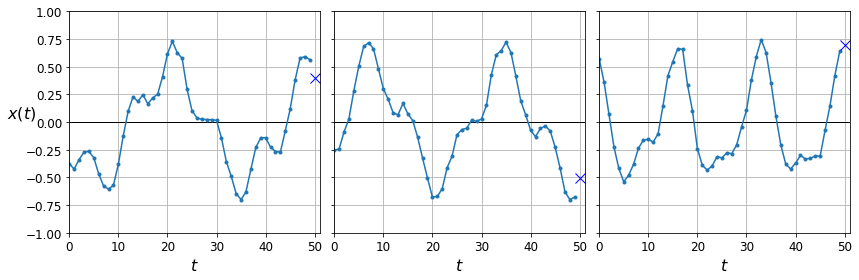

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("r_15_6")
plt.show()

### Obliczenia bazowe

Prognozy naiwne (prognozowanie ostatniej zaobserwowanej wartości):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

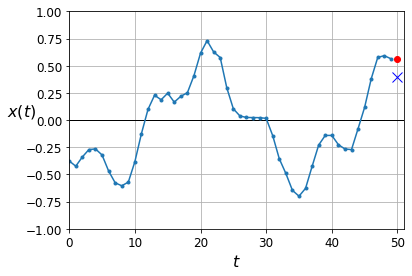

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Prognozy liniowe:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 365us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 1s 93us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 1s 90us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 1s 92us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 1s 91us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 93us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 91us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 1s 89us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [9]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 47us/sample - loss: 0.0041


0.004145486194640398

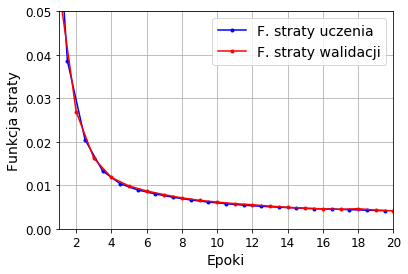

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="F. straty uczenia")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="F. straty walidacji")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epoki")
    plt.ylabel("Funkcja straty")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

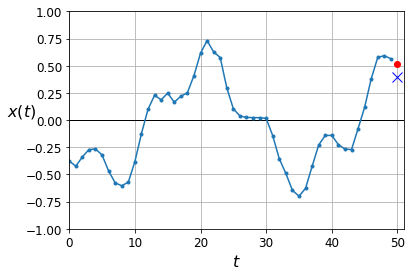

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Korzystanie z prostej sieci rekurencyjnej

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0255 - val_loss: 0.0220
Epoch 4/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0200 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0167 - val_loss: 0.0152
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0147 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 7s 974us/sample - loss: 0.0119 - val_loss: 0.0113
Epoch 10/20
70

In [13]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 174us/sample - loss: 0.0109


0.010885455287992955

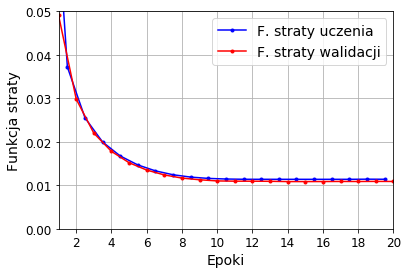

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

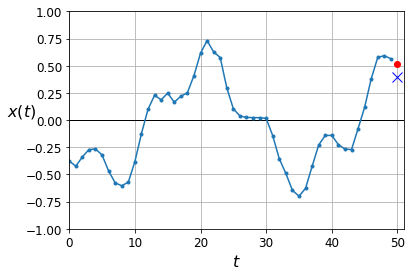

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Głębokie sieci rekurencyjne

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0051 - val_loss: 0.0043
Epoch 4/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0040 - val_loss: 0.0038
Epoch 6/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0038 - val_loss: 0.0042
Epoch 7/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0034 - val_loss: 0.0038
Epoch 1

In [17]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 372us/sample - loss: 0.0029


0.002934106146916747

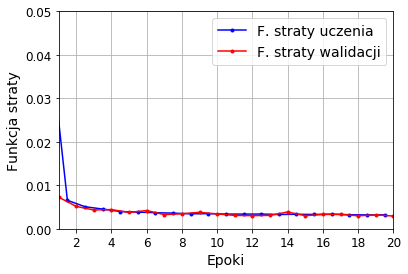

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

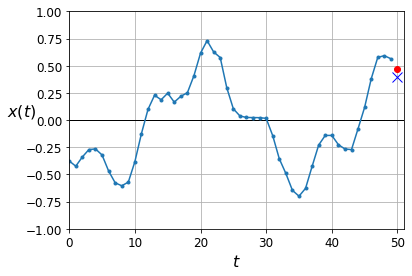

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Sprawmy, aby druga warstwa `SimpleRNN` zwracała tylko ostatni wynik:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0221 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0030 - val_loss: 0.0029
Epoch 1

In [21]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 273us/sample - loss: 0.0026


0.0025768041349947452

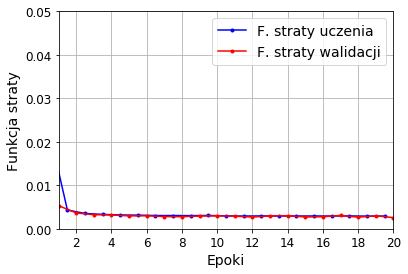

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

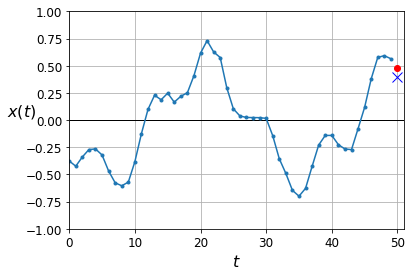

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Prognozowanie kilka taktów naprzód

In [0]:
np.random.seed(43) # nie 42, ponieważ otrzymalibyśmy w ten sposób pierwszy szereg w zestawie uczącym

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [25]:
Y_pred.shape

(1, 10, 1)

Zapisywanie rysunku r_15_8


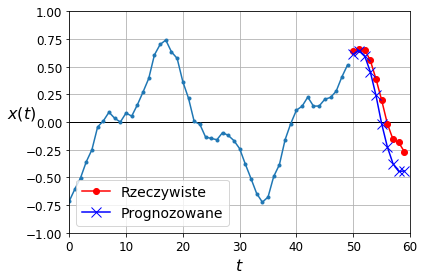

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Rzeczywiste")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Prognozowane", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("r_15_8")
plt.show()

Użyjmy teraz tego modelu do prognozowania dziesięciu następnych wartości. Musimy najpierw ponownie wygenerować sekwencje składające się z co najmniej dziewięciu taktów.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Prognozujmy teraz kolejno dziesięć następnych wartości:

In [0]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.02727729

Porównajmy wydajność z metrykami bazowymi: prognozami naiwnymi i prostym modelem liniowym:

In [31]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 116us/sample - loss: 0.1348 - val_loss: 0.0610
Epoch 2/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0501 - val_loss: 0.0427
Epoch 3/20
7000/7000 [==============================] - 1s 86us/sample - loss: 0.0388 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 1s 86us/sample - loss: 0.0334 - val_loss: 0.0314
Epoch 5/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0299 - val_loss: 0.0286
Epoch 6/20
7000/7000 [==============================] - 1s 83us/sample - loss: 0.0275 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0258 - val_loss: 0.0251
Epoch 8/20
7000/7000 [==============================] - 1s 83us/sample - loss: 0.0245 - val_loss: 0.0237
Epoch 9/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 

Stwórzmy teraz sieć rekurencyjną, przewidującą równocześnie dziesięć następnych wartości:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0138 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0132 - val_loss: 0.0117
Epoch 7/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0115 - val_loss: 0.0119
Epoch 9/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0110 - val_loss: 0.0113
Epoch 1

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

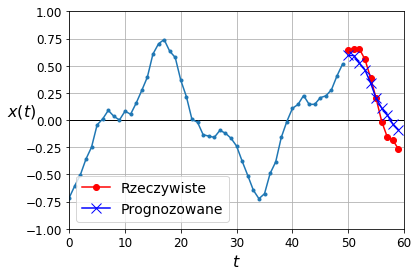

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Stwórzmy teraz sieć rekurencyjną, przewidującą dziesięć następnych etapów w każdym takcie. Inaczej mówiąc, nie będzie ona prognozować taktów od 50. do 59. na podstawie taktów 0.-49., lecz takty od 1. do 10. w takcie 0., następnie takty od 2. do 11. w takcie 1. itd., a na końcu będzie prognozować takty od 50. do 59. w ostatnim takcie. Zwróć uwagę, że model ten jest przyczynowy: w każdej prognozie może posługiwać się wyłącznie wcześniejszymi taktami.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0389 - last_time_step_mse: 0.0282 - val_loss: 0.0320 - val_last_time_step_mse: 0.0196
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0328 - last_time_step_mse: 0.0218 - val_loss: 0.0297 - val_last_time_step_mse: 0.0186
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0292 - last_time_step_mse: 0.0180 - val_loss: 0.0282 - val_last_time_step_mse: 0.0175
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0272 - last_time_step_mse: 0.0155 - val_loss: 0.0269 - val_last_time_step_mse: 0.0147
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0246 - last_time_step_mse: 0.0121 - 

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

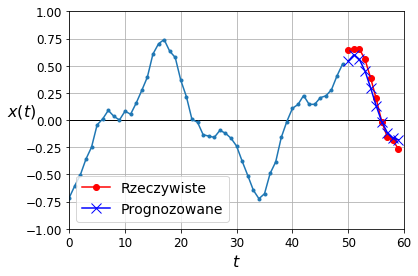

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Głęboka sieć rekurencyjna z normalizacją wsadową

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.1936 - last_time_step_mse: 0.1913 - val_loss: 0.0901 - val_last_time_step_mse: 0.0863
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0531 - last_time_step_mse: 0.0441 - val_loss: 0.0559 - val_last_time_step_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0423 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0414 - last_time_step_mse: 0.0310 - val_loss: 0.0402 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0390 - last_time_step_mse: 0.0283 - 

# Głębokie sieci rekurencyjne z normalizacją warstw

In [0]:
from tensorflow.keras.layers import LayerNormalization

In [0]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 27s 4ms/sample - loss: 0.1570 - last_time_step_mse: 0.1503 - val_loss: 0.0719 - val_last_time_step_mse: 0.0664
Epoch 2/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0630 - last_time_step_mse: 0.0562 - val_loss: 0.0564 - val_last_time_step_mse: 0.0494
Epoch 3/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0538 - last_time_step_mse: 0.0464 - val_loss: 0.0504 - val_last_time_step_mse: 0.0430
Epoch 4/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0488 - last_time_step_mse: 0.0411 - val_loss: 0.0455 - val_last_time_step_mse: 0.0374
Epoch 5/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0425 - last_time_step_mse: 0.0329 - val_loss: 0.0393 - val_last_time_step_mse: 0.0286
Epoch 6/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0386 - last_time_step_mse: 0.0278 - 

# Tworzenie niestandardowej klasy rekurencyjnej

In [0]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.2154 - last_time_step_mse: 0.2040 - val_loss: 0.0870 - val_last_time_step_mse: 0.0769
Epoch 2/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0723 - last_time_step_mse: 0.0607 - val_loss: 0.0627 - val_last_time_step_mse: 0.0510
Epoch 3/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0577 - last_time_step_mse: 0.0439 - val_loss: 0.0535 - val_last_time_step_mse: 0.0392
Epoch 4/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0508 - last_time_step_mse: 0.0364 - val_loss: 0.0486 - val_last_time_step_mse: 0.0332
Epoch 5/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0462 - last_time_step_mse: 0.0322 - val_loss: 0.0444 - val_last_time_step_mse: 0.0302
Epoch 6/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0430 - last_time_step_mse: 0.0292 - 

# Komórki LSTM

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 636us/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 2s 292us/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 2s 309us/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 2s 283us/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 2s 288us/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 2s 284us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [48]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 137us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.02401665513217449, 0.008551416]

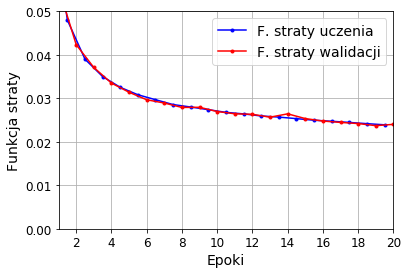

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

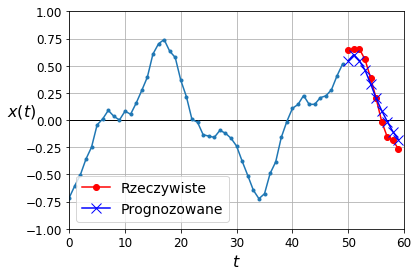

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Komórki GRU

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 591us/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 2s 286us/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 2s 262us/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 2s 266us/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 2s 264us/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 2s 266us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [53]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 128us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.024071006208658218, 0.01029832]

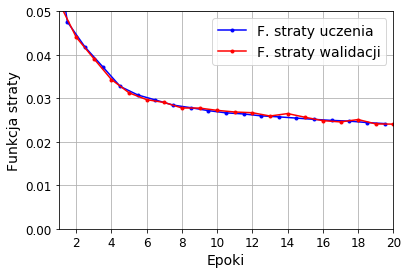

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

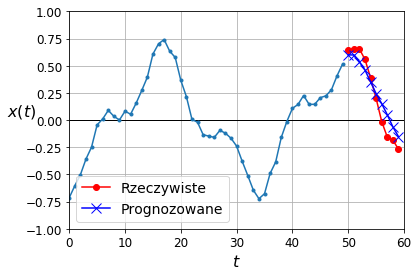

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Stosowanie jednowymiarowych warstw splotowych w przetwarzaniu sekwencji

```
Jednowymiarowa warstwa splotowa z jądrem o rozmiarze 4, kroku równym 2 i uzupełnianiu zerami typu VALID:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Wynik:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 582us/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 2s 228us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 2s 241us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 2s 230us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 2s 225us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 2s 231us/sample - loss: 0.0230 - last_time_step_mse: 0.0

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 379us/sample - loss: 0.0684 - last_time_step_mse: 0.0550 - val_loss: 0.0385 - val_last_time_step_mse: 0.0248
Epoch 2/20
7000/7000 [==============================] - 1s 189us/sample - loss: 0.0340 - last_time_step_mse: 0.0215 - val_loss: 0.0306 - val_last_time_step_mse: 0.0183
Epoch 3/20
7000/7000 [==============================] - 1s 189us/sample - loss: 0.0294 - last_time_step_mse: 0.0174 - val_loss: 0.0277 - val_last_time_step_mse: 0.0157
Epoch 4/20
7000/7000 [==============================] - 1s 199us/sample - loss: 0.0273 - last_time_step_mse: 0.0156 - val_loss: 0.0266 - val_last_time_step_mse: 0.0150
Epoch 5/20
7000/7000 [==============================] - 1s 189us/sample - loss: 0.0259 - last_time_step_mse: 0.0142 - val_loss: 0.0251 - val_last_time_step_mse: 0.0134
Epoch 6/20
7000/7000 [==============================] - 1s 192us/sample - loss: 0.0249 - last_time_step_mse: 0.0

Poniżej prezentuję oryginalną sieć WaveNet, zdefiniowaną w artykule: wykorzystuje ona jednostki aktywacji bramkowanej zamiast funkcji ReLU, a także parametryzowane połączenia pomijające, a do tego uzupełnia zerami lewą stronę w celu uniknięcia coraz krótszych sekwencji:

In [0]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [0]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 w artykule
n_blocks = 1 # 3 w artykule
n_filters = 32 # 128 w artykule
n_outputs = 10 # 256 w artykule

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 3s 422us/sample - loss: 0.1299 - last_time_step_mse: 0.1258 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
7000/7000 [==============================] - 1s 201us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190


W tym rozdziale poznaliśmy podstawy sieci rekurencyjnych i wykorzystaliśmy je do przetwarzania sekwencji (mianowicie szeregów czasowych). Przyjrzeliśmy się również innym sposobom przetwarzania sekwencji, w tym również za pomocą sieci splotowych. W następnym rozdziale wykorzystamy sieci rekurencyjne w zadania przetwarzania języka naturalnego, a także poznamy ich kolejne odmiany (dwukierunkowe, stanowe i bezstanowe, modele typu koder-dekoder, a także zastosowania mechanizmów uwagi). Omówię także transformatory, czyli modele bazujące wyłącznie na mechanizmach uwagi.

# Rozwiązania ćwiczeń

## 1. do 6.

Zobacz dodatek A.

## 7. Osadzone gramatyki Rebera

Najpierw musimy stworzyć funkcję generującą łańcuchy znaków na podstawie jakiejś gramatyki. Gramatyka ta będzie reprezentowana jako lista możliwych przejść dla każdego stanu. Za pomocą przejścia wyznaczamy łańcuch znaków na wyjściu (lub gramatykę służącą do wygenerowania tego łańcucha) i następny stan.

In [0]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (stan 0.) =B=>(stan 1.)
    [("T", 2), ("P", 3)], # (stan 1.) =T=>(stan 2.) lub =P=>(stan 3.)
    [("S", 2), ("X", 4)], # (stan 2.) =S=>(stan 2.) lub =X=>(stan 4.)
    [("T", 3), ("V", 5)], # i tak dalej...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (stan 6.) =E=>(stan końcowy)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Wygenerujmy kilka łańcuchów znaków bazujących na domyślnej gramatyce Rebera:

In [0]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Wygląda dobrze. Wygenerujmy teraz kilka łańcuchów znaków na podstawie osadzonej gramatyki Rebera:

In [0]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

W porządku, potrzebna jest nam teraz funkcja generująca łańcuchy zgodnie z regułami gramatyki. Moglibyśmy wygenerować losowy łańcuch znaków, ale byłoby to zbyt proste, dlatego wygenerujemy łańcuch znaków przestrzegający zasad gramatyki i uszkodzimy go za pomocą tylko jednego znaku:

In [0]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Przyjrzyjmy się kilku uszkodzonym łańcuchom znaków:

In [0]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

Ciąg dalszy nastąpi...